![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with SHAP

In this Notebook we will demonstrate how to use the SHapley Additive exPlanations (SHAP) and interpret the Shapley values, plots, and other information produced by the SHAP package.

This tutorial is under the MPL 2.0 licence and is based on a [tutorial by Andrew Fairless](https://afairless.com/shap-tutorial/).

--------

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/tutorial_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use.
There are few things you should follow in order to properly set the notebook up:

1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [ ]:
# %pip install shap

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [ ]:
# Create a folder in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo in the first part of the tutorial
# !git clone https://github.com/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI.git  

In [ ]:
# %cd Zero2Hero---Introduction-to-XAI/xai-model-agnostic

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import shap

Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

## The California Housing Dataset: Data Loading and Model Training

Let's use the California housing data set. The dataset is introduced in detail in the permutation importance notebook. Check it out, if you like to have more information on this dataset.

In [3]:
calif_house_data = fetch_california_housing()
X = pd.DataFrame(calif_house_data['data'], columns = calif_house_data['feature_names'])
y = pd.DataFrame(calif_house_data['target'], columns=['Price'])

For the sake of runtime we limit ourselves to only the first 2000 samples. We will split parts of the data, so the model can not use all the available information for training. That way, we can also check performance and interpretation results on previously unseen data, mirroring the most probable practical use case.

In [4]:
# take only first 2000 samples and convert all data frames to numpy array, which is required for SHAP
feature_names = X.columns
X = X[:2000]
y = y[:2000]

# split off the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=seed)
print('Number of training samples: {}'.format(X_train.shape[0]))
print('Number of test samples: {}'.format(X_test.shape[0]))


Number of training samples: 1500
Number of test samples: 500


We'll create a Random Forest regression model to predict our *price* target variable from the other features, after they have been properly rescaled to each have zero mean and unit standard deviation.  
Don't worry for now if you are not familiar with the model. It is just meant as a protoype of a model that is not straightforward to interpret.

Please note that we are passing a numpy array whenever we are calling a Pipeline object (named _pipe_ in our case). Pandas dataframe is converted into a numpy array by running the _.values_ method. Even though Pipeline works also with the pandas dataframes, we are doing that in order to avoid the warning coming from *shap_values* function that we use later on. 

In [5]:
pipe = Pipeline([
    ("preprocessing", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=500,max_depth=5,random_state=42))
])

pipe.fit(X_train.values, y_train.values)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=5, n_estimators=500,
                                       random_state=42))])

In [6]:
# is the model performing reasonably on the training data?
print('Model Performance on training data: {}'.format(pipe.score(X_train.values, y_train.values)))

# is the model performing reasonably on the test data?
print('Model Performance on test data: {}'.format(pipe.score(X_test.values, y_test.values)))

Model Performance on training data: 0.8295001033150897
Model Performance on test data: 0.825688283372032


Since model training and tuning is not a focus of this course, we will not try to improve the model performance further.  
**Note:** you should keep in mind that interpreting a low performing model can lead to wrong conclusions.

Now that we trained a regression model which predicts the prices relatively well, but might be a bit hard to interpet directly, we can make use of SHAP to help us out.

## Now, what does my model actually think is important in the data?

### SHapley Additive exPlanations (SHAP)

Let's use **SHAP** to explain our model's predictions.

We prepared a small [video lecture](https://vimeo.com/745352008/3168320cef) for you to help you understand how SHAP works and how Shapley values are computed.

In [7]:
from IPython.display import VimeoVideo

VimeoVideo("745352008?h=3168320cef", width=800, height=600)

To summarize, SHAP is a method that enables a fast computation of Shapley values and can be used to explain the prediction of an instance x by computing the contribution (Shapley value) of each feature to the prediction. We get contrastive explanations that compare the prediction with the average prediction. The fast computation makes it possible to compute the many Shapley values needed for the global model interpretations. With SHAP, global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations. If you use LIME for local explanations and permutation feature importance for global explanations, you lack a common foundation. SHAP provides KernelSHAP, an alternative, kernel-based estimation approach for Shapley values inspired by local surrogate models, as well as TreeSHAP, an efficient estimation approach for tree-based models. 


**Note:** this method is a **local** method which means that it only provides explanations for individual samples. However, the individual explanations can be used to also get **global** interpretations. 

Now lets use SHAP to get some insights into the Kernel Ridge regression model we trained above. The *shap.Explainer()* function uses the shap values to explain any machine learning model. Here we use KernelSHAP (*shap.KernelExplainer()*) to calculate our Shapley values. KernalSHAP is an alternative, kernel-based estimation approach for Shapley values inspired by local surrogate models. If you are calculating Shapley values for tree-based methods, you could use TreeSHAP (*shap.TreeExplainer()*) instead, which provides a fast, model-specific alternative to KernelSHAP. As data you should use a subset of your original training data, as the Shapley value calculation takes quite some time. That is why we limit ourselves to only the first 100 examples of the training data.

In [8]:
# the first 100 rows
n_rows = 100
X_shap = X_train[:n_rows]
y_shap = y_train[:n_rows]
predictions_shap = pd.DataFrame(pipe.predict(X_train[:n_rows].values), columns = ['Predicted Price'])

In [9]:
# run SHAP
explainer = shap.KernelExplainer(pipe.predict, X_shap)
shap_values = np.reshape(explainer.shap_values(X_shap), (n_rows,-1))

  0%|          | 0/100 [00:00<?, ?it/s]

Notice that the shapley values matrix is the same size as our input matrix that contains all the feature values for each observation (i.e., each row of the matrix). That means that there is one Shapley value for each entry in our feature matrix. Hence, each observation (row) has a Shapley value for each of its features (columns) that explains that feature's contribution to the model's prediction for that observation.

In [10]:
print('Features matrix - # samples: {}, # features: {}'.format(X_shap.shape[0], X_shap.shape[1]))
print('SHAP values matrix - # samples: {}, # features: {}'.format(shap_values.shape[0], shap_values.shape[1]))

Features matrix - # samples: 100, # features: 8
SHAP values matrix - # samples: 100, # features: 8


The SHAP values explain why a prediction for a single observation is different from the average prediction for all the observations in the data set. Here's our model's average prediction for our data set:

In [11]:
# average prediction for the dataset
print('Models average prediction for our data set: {}'.format(explainer.expected_value))

Models average prediction for our data set: 1.8965385727394253


### Local Explanations with SHAP

The SHAP package provides some visualizations to help us understand how much each feature contributes to each prediction. Let's look at a prediction for a single observation (row) in our data set.

In [12]:
observation_of_interest = 3
print('Models prediction for the observation of interest: {}'.format(predictions_shap.iloc[observation_of_interest]))

Models prediction for the observation of interest: Predicted Price    1.960802
Name: 3, dtype: float64


#### Decision Plot

Here is the SHAP package's *decision plot* for explaining why a single
    observation deviates from the average prediction:

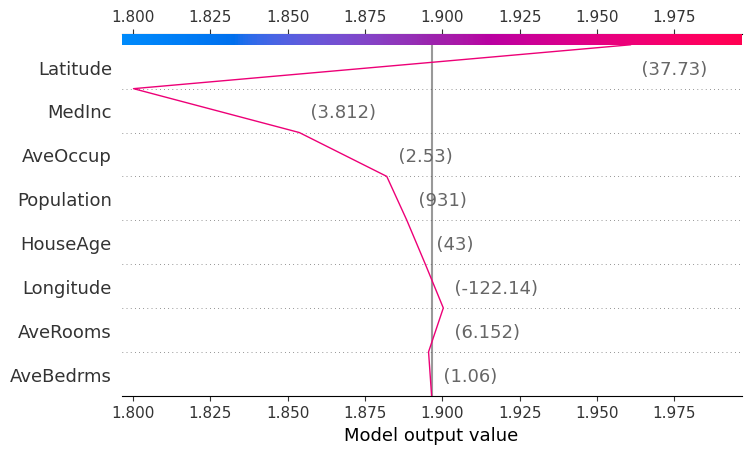

In [13]:
shap.decision_plot(
    explainer.expected_value, 
    shap_values[observation_of_interest], 
    X_shap.iloc[observation_of_interest])

It's probably the easiest to read this plot from the bottom to the top. At the
    bottom, the blue line starts at the average prediction for the
    whole data set. Then as we move up the plot row by row, we're looking at
    each feature's effect on the prediction for our single observation, given the 
    current set of feature values. If the line moves a lot to the left or right, 
    then the feature for that row changes the prediction by a lot.

**Note:** The Shapley value can be misinterpreted. The Shapley value of a feature value is not the difference of the predicted value after removing the feature from the model training.  
The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value.

As we move from the bottom to the top of the plot, we notice that *AveBedrms*, *AveRooms*, *Longitude*, *HouseAge* and *Population* have only a small impact on the prediction, whereas *AveOccup*, *MedInc* and *Latitude* have larger effects.

The values in parentheses in each row show the value for each feature for the
    houses in this census block. So, we can see that houses in this block
    are 43 years old on average and have an average occupancy of 2.53. 

As we move further up the plot, we notice that the census block's *MedInc* strongly decreases the predicted median price, according to our model, while the *Latitude* value strongly increases the median price of the houses.

When we sum up all the SHAP-calculated effects of the features, we see that
    the model predicts that the median price for houses in this census block
    is about 1.96. This can be read off the plot directly: it's where the blue squiggly line ends up at the top of the plot.
    The value for this sample is below 1.89 (from which the decision plot started at the bottom), the average predicted median price 
    for all houses in all the census blocks in the data set we used to compute the shapley values.

#### Force Plot

The SHAP package provides another type of plot, the *force plot*, to visualize
    the same information as the *decision plot* that we discussed above:

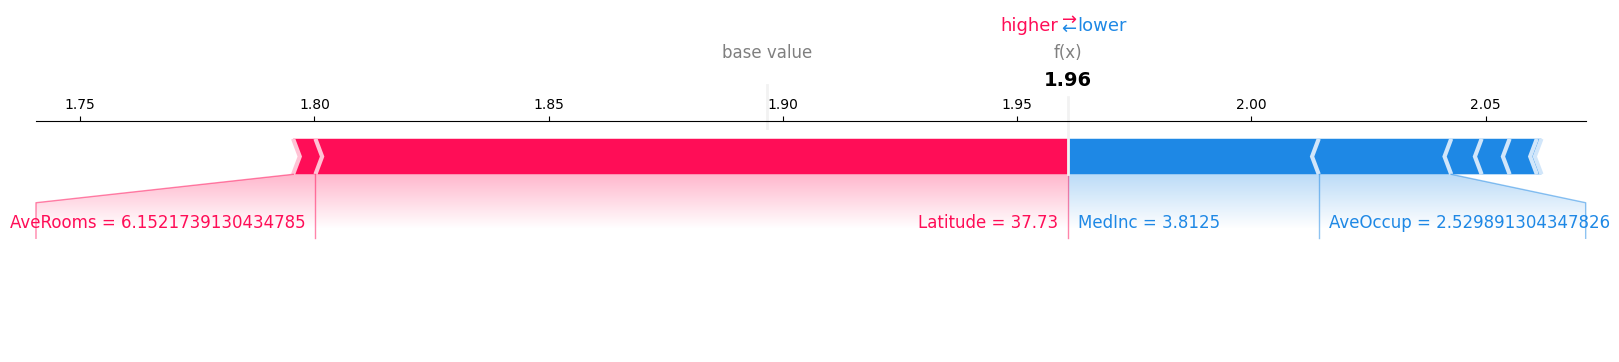

In [14]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[observation_of_interest], 
    X_shap.iloc[observation_of_interest], 
    matplotlib=True)

In this *force plot*, the information that we saw in the *decision plot* is
    vertically squashed, or compressed.  The effects of all the features now
    appear on a single row, instead of each feature appearing on its own row.
    This visualization is more compact, but we can still see the same
    information that we saw in the *decision plot*.

The average prediction for all houses in all the census blocks is labeled
    as the *base value* here which is about 1.89. The predicted median price for houses in this
    census block is 1.96 and is labeled as the *f(x)*.

Features that increase the predicted price from the *base value* are in red and
    are distinguished from each other by arrows pointing to the right.  Features
    that decrease the predicted price are in blue and have left-pointing
    arrows.  Features with larger effects on the prediction occupy more space
    in the row of arrows.  The two sets of features point to the *output value*.
    The names of the features and their values are printed below the row of
    arrows.

### Global Explanations with SHAP

#### Force Plot

Now that we understand the *force plot* for a single observation, we can look
    at a force plot for our 100 selected observations.

In [15]:
# run the SHAP Java initializer, that is needed to create the plot
shap.initjs()

shap.force_plot(
    explainer.expected_value, 
    shap_values, 
    X_shap)

In the *force plot* for a single observation, we had a horizontal row of red
    and blue arrows.  For this *force plot* of many observations, the rows of
    red and blue arrows have been rotated so that the arrows for a single
    observation are now vertical.  We can look horizontally across our entire
    sampled data set and easily see approximately how many observations have
    high predictions or average predictions or low predictions (where the red
    and blue areas meet). We can also see which features tend to push these
    predictions up or down. Hover with your mouse over section of the plot to get information about single samples.

#### Feature Importances Summary Plot

The *force plot* for many observations is great for looking at the model's
    predictions with granularity.  But what if we want a simpler summary of
    how important each feature is in making predictions for the entire data
    set - something like *feature importance*?

The SHAP package provides this as a *summary plot*.  Here it is for our data:

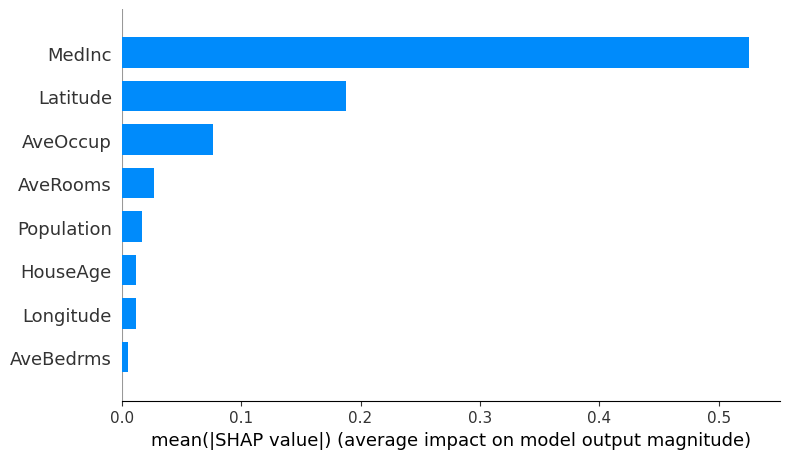

In [16]:
shap.summary_plot(
    shap_values, 
    X_shap, 
    plot_type='bar')

Those feature importances are calculated simply by taking the
    absolute values of all the Shapley values and averaging them for each
    feature.  Look closely, and you can see that the calculation below matches
    the plot *summary plot* above.

In [17]:
pd.Series(np.abs(shap_values).mean(axis=0), index=feature_names).sort_values(ascending=False)

MedInc        0.524890
Latitude      0.187615
AveOccup      0.076754
AveRooms      0.027097
Population    0.016832
HouseAge      0.012067
Longitude     0.011702
AveBedrms     0.005425
dtype: float64

Just to make sure we understand what's happening here. Remember, each row is an observation, which represents a census block of houses,
    and we have 100 census blocks.  Each column is a feature, and there are 8 features.

All we did in the calculation above was to average all the (absolute values of
    the) 100 Shapley values in each column.  That gave us 8 sums, one for each
    feature, and those are our 8 feature importances for this model.  It's that
    simple.

Let's pause and consider this for a moment, because this is a really important
    point:  the feature importances for the entire model are calculated
    directly from their importances for individual observations.  In other
    words, the importances are consistent between the model's global behavior
    and its local behavior.  This consistency is a remarkable and really
    important characteristic that many model interpretability methods do not
    offer.

The SHAP package also provides a more granular look at feature importances for
    the entire data set.

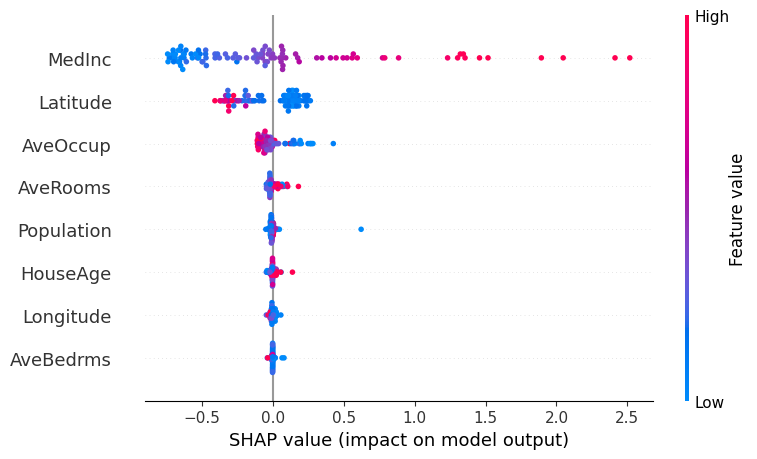

In [18]:
shap.summary_plot(
    shap_values, 
    X_shap)

Here the Shapley values of every observation are plotted for each feature.
    Additionally, the coloring indicates whether low (or high) values of each
    feature increase (or decrease) the model's predictions.

For example, we can see that high median incomes (*MedInc*) increase the
    predictions of house prices (i.e., the Shapley values are greater than zero)
    while low median incomes decrease those predictions (i.e., the Shapley
    values are < 0).  Also, the effects of *MedInc* on the model's predictions
    exhibit a positively skewed distribution:  most values of *MedInc*
    decrease the model's predictions, while a long tail of high *MedInc*
    values increase the model's predictions.

With *AveOccup*, there is a similar effect in the opposite direction. Low values of average occupancy
    increase the model's predictions.

<font color='green'>

#### Question 1: What does the shapley value tell you about the effect of the feature on a prediction?

<font color='grey'>

#### Your Answer: 

It tells you by how much the specific feature is moving the sample’s prediction away from the mean prediction of all samples.

<font color='green'>

#### Question 2: What are the differences to the permutation importance method?

<font color='grey'>

#### Your Answer: 

- The shapley-value itself tells you something about the absolute effect of a feature on the output.
- To get the importance of a feature all possible combinations of feature subsets with and without the feature of interest are computed.
- Shapley is based only on model prediction and not on performance metric.


<font color='green'>

#### Question 3: What is the main limitation of shapley values and why?

<font color='grey'>

#### Your Answer: 

That it is computationally expensive, especially for large models and large features sets, as you need to compute all possible combinations of features. Also problem with complex correlations.

## Extra Material: Interpretation of a Random Forest Classifier that Predicts Wine Quality

Let's use the wine quality dataset. Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests.

<center><img src="./figures/red_wine.jpg" width="1200" /></center>

<font size=1> Source:\
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

In [19]:
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier

In [20]:
wine_data = load_wine()

Now, let's have a look at the description of the dataset:

In [21]:
print(wine_data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

Let's put all of our data into a data frame:

In [22]:
X = pd.DataFrame(wine_data['data'], columns = wine_data['feature_names'])
y = pd.DataFrame(wine_data['target'], columns=['Quality'])

See how many samples and features we have in the dataset and how their values are distributed:

In [23]:
print('Features: {}'.format(list(X.columns)))
print('# samples: {}, # features: {}'.format(len(X.index), len(X.columns)))

Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
# samples: 178, # features: 13


In [24]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [25]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [26]:
y.head()

,Quality
0,0
1,0
2,0
3,0
4,0


In [27]:
y.describe()

,Quality
count,178.000000
mean,0.938202
std,0.775035
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


The data set has 178 observations, 13 features, and 1 target variable. The target variable *quality* is categorical with three classes (low, medium, good quality), so we can predict the classes using the other available features with a classification model of our choice.

In [28]:
# split off the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=seed)
print('Number of training samples: {}'.format(X_train.shape[0]))
print('Number of test samples: {}'.format(X_test.shape[0]))

Number of training samples: 133
Number of test samples: 45


We'll create a Random Forest Classifier to predict our *quality* target variable from the other features, after they have been properly rescaled to each have zero mean and unit standard deviation.  
Don't worry for now if you are not familiar with the model. It is just meant as a protoype of a model that is not straightforward to interpret.

In [29]:
pipe = Pipeline([
    ("preprocessing", StandardScaler()),
    ("model", RandomForestClassifier())
])
# We use ravel() to transform the shape of y_train to (n_samples, ), as needed for the RandomForestClasifier
pipe.fit(X_train.values, y_train.values.ravel())

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('model', RandomForestClassifier())])

Now that the model is fit, let's check its performance as measured by the mean accuracy metric for both the training and the validation data.

In [30]:
# is the model performing reasonably on the training data?
print('Model Performance on training data: {}'.format(pipe.score(X_train, y_train)))

# is the model performing reasonably on the test data?
print('Model Performance on test data: {}'.format(pipe.score(X_test, y_test)))

Model Performance on training data: 1.0
Model Performance on test data: 0.9777777777777777


X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


<font color='green'> 

#### Task   
    
</font>

Write your own code to study the impact of different features on the output for the instance with $index = 23$. Use a *TreeExplainer()* and create a force plot to verify that *proline* is the feature that contributes the most to decreasing the quality of the wine analized.

## Additional Resources

This concludes our exploration of how to use Shapley values and the SHAP
    package. To learn more about Shapley values, the SHAP package, and how these are used to
    help us interpret our machine learning models, please refer to these
    resources:


- [A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)
    > Scott Lundberg, Su-In Lee

- [Consistent feature attribution for tree ensembles](https://arxiv.org/abs/1706.06060)
    > Scott M. Lundberg, Su-In Lee

- [Consistent Individualized Feature Attribution for Tree Ensembles](https://arxiv.org/abs/1802.03888)
    > Scott M. Lundberg, Gabriel G. Erion, Su-In Lee

- [A game theoretic approach to explain the output of any machine learning model.](https://github.com/slundberg/shap)
    >

- [Interpretable Machine Learning:  A Guide for Making Black Box Models Explainable.  5.9 Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
    > Christoph Molnar, 2019-12-17

- [Interpretable Machine Learning:  A Guide for Making Black Box Models Explainable.  5.10 SHAP (SHapley Additive exPlanations](https://christophm.github.io/interpretable-ml-book/shap.html)
    > Christoph Molnar, 2019-12-17

- [Interpretable Machine Learning with XGBoost](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27?gi=187ef710fdda)
    > Scott Lundberg, Apr 17, 2018

- [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)
    > Dataman, Sep 14, 2019


Additionally, Christoph Molnar's book and Tim Miller's paper can provide further insight into the
    challenges and promise of machine learning interpretability:

- [Interpretable Machine Learning:  A Guide for Making Black Box Models Explainable.](https://christophm.github.io/interpretable-ml-book/)
    > Christoph Molnar, 2019-12-17

- [Explanation in Artificial Intelligence: Insights from the Social Sciences](https://arxiv.org/abs/1706.07269)
    > Tim Miller